# FINAL NPxZxD PROTOTYPE

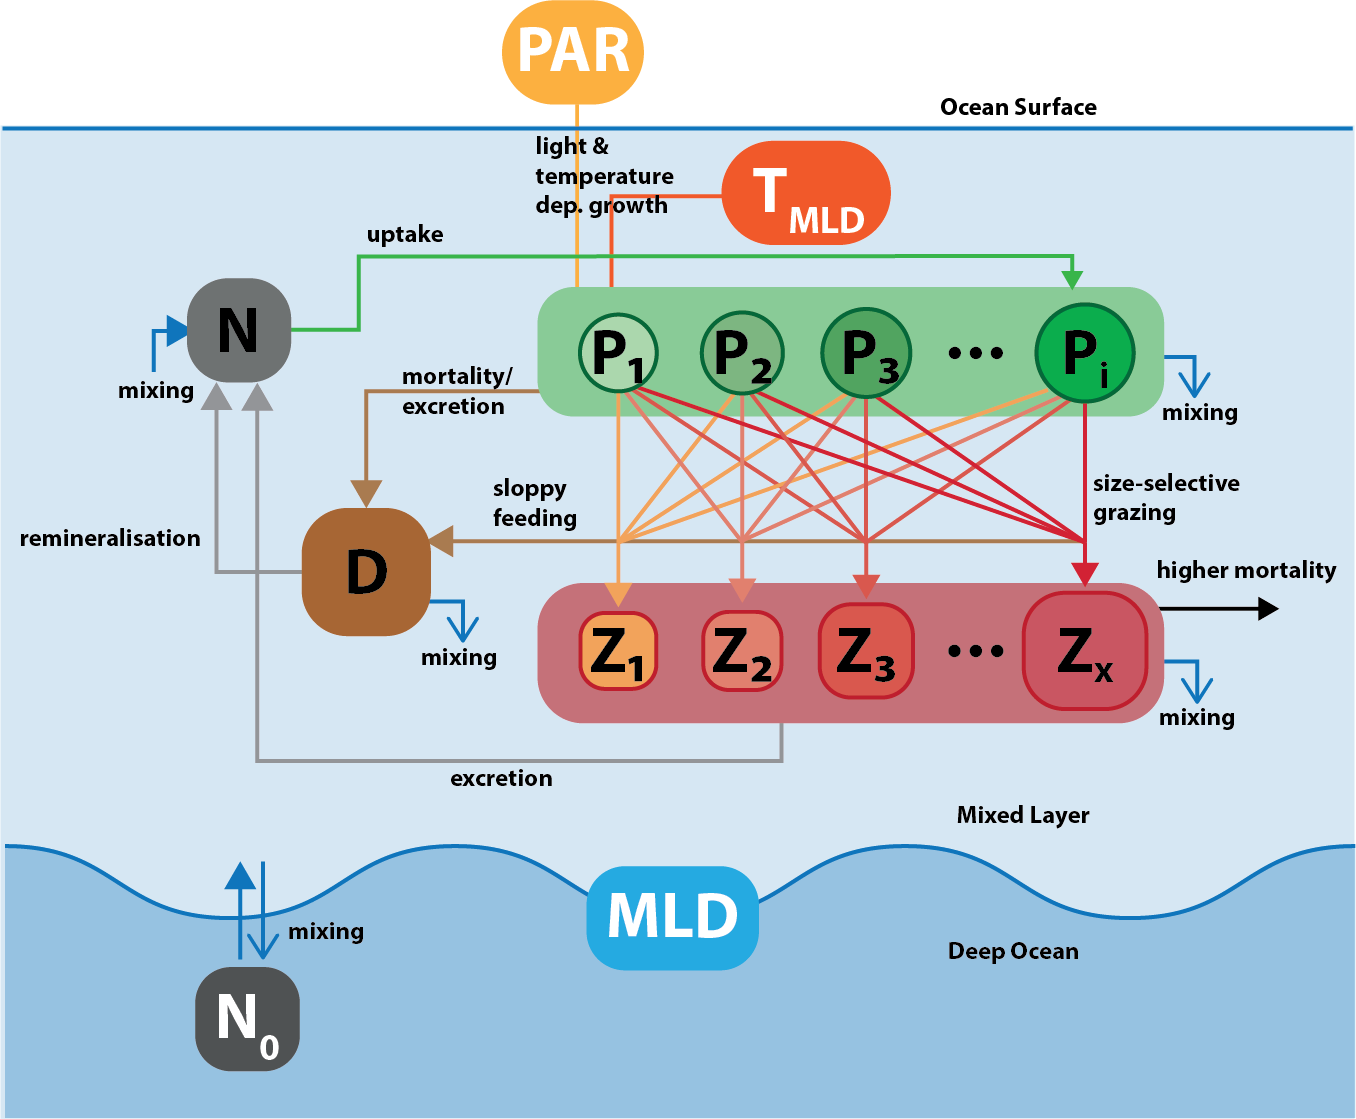

In [1]:
from IPython.display import Image
Image(filename=('NPxZxDslab_schematics.png'), width=500)

In [2]:
import numpy as np
# to check for array handling errors:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)

import matplotlib.pyplot as plt

# Parameter helping functions

In [3]:
def calculate_sizes(size_min, size_max, num):
    """initializes log spaced array of sizes from ESD size range"""
    numbers = np.array([i for i in range(num)])
    sizes = (np.log(size_max) - np.log(size_min))* numbers / (num-1) + np.log(size_min)
    return np.exp(sizes)

In [4]:
calculate_sizes(2,200,20)

array([  2.        ,   2.54854997,   3.24755348,   4.13827616,
         5.2733018 ,   6.71963657,   8.5626648 ,  10.91118956,
        13.90385592,  17.71733581,  22.57675783,  28.76899777,
        36.65961422,  46.71442938,  59.52702883,  75.85380381,
        96.65860477, 123.16964221, 156.95199407, 200.        ])

In [5]:
def initialize_alloparams(self):
    """initializes allometric parameters based on array of sizes (ESD)"""
    self.I0 = 26 * (self.size) ** -0.4 #* .5
    self.xpreyopt = 0.65 * (self.size) ** .56 # which should equal = self.phytosize

def initialize_alloparams(self):
    """initializes allometric parameters based on array of sizes (ESD)
    allometric relationships are taken from meta-analyses of lab data"""
    self.mu0 = 2.6 * (self.size) ** -0.45
    self.ks = (self.size) * .1

In [6]:
import numpy as np

In [7]:
phytosize = calculate_sizes(2,200,3)
xpreyopt = phytosize # calculate_sizes(20,400,3)


def init_phiP():
    """creates array of feeding preferences [P...P10] for each [Z]"""
    phiP = np.array([[np.exp(-((np.log10(xpreyi) - np.log10(xpreyoptj)) / 0.25) ** 2)
                      for xpreyi in phytosize] for xpreyoptj in xpreyopt])
    return phiP

phiP = init_phiP()
phiP

array([[1.00000000e+00, 1.12535175e-07, 1.60381089e-28],
       [1.12535175e-07, 1.00000000e+00, 1.12535175e-07],
       [1.60381089e-28, 1.12535175e-07, 1.00000000e+00]])

# Model building

In [8]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [9]:
from phydra.components.variables import SV, SVArray

from phydra.components.fluxes.basic import LinearDecay, LinearExchange, QuadraticDecay, QuadraticExchange
from phydra.components.fluxes.basic_dims import (LinearDecay_Dim, LinearExchange_SourceDim, 
                                                 QuadraticDecay_Dim, QuadraticExchange_SourceDim)
from phydra.components.fluxes.growth_multi_lim import (Growth_ML_ConsumerDim, Eppley_ML_ConsumerDim, 
                                                       Monod_ML_ConsumerDim, Steele_ML_ConsumerDim)
from phydra.components.fluxes.grazing import (HollingTypeIII_ResourcesListInput_Consumption2Group,
                                              SizebasedGrazingKernel_Dims,
                                              GrossGrowthEfficiency_MatrixGrazing,
                                              GrossGrowthEfficiency)
from phydra.components.fluxes.ocean_physics import SlabUpwelling, SlabMixing, SlabSinking

from phydra.components.forcings import GlobalSlabClimatologyForcing

In [10]:
NPxZxD = phydra.create({
    # State variables
    'Nutrient':SV,
    'Phytoplankton':SVArray,
    'Zooplankton':SVArray,
    'Detritus':SV,
    
    # Mixing:
    'Upwelling':SlabUpwelling,
    'Mixing':SlabMixing,
    'Sinking':SlabSinking,

    # Growth
    'Growth':Growth_ML_ConsumerDim,
    'Monod':Monod_ML_ConsumerDim,
    'Steele':Steele_ML_ConsumerDim,
    'Eppley':Eppley_ML_ConsumerDim,
    
    # Grazing
    'Grazing':SizebasedGrazingKernel_Dims,
    'GGE':GrossGrowthEfficiency_MatrixGrazing,
    
    # Mortality 
    'PhytoLinMortality':LinearExchange_SourceDim,
    'PhytoQuadMortality':QuadraticExchange_SourceDim,
    'ZooLinMortality':LinearExchange_SourceDim,
    'HigherOrderPred':QuadraticDecay_Dim,
    'DetRemineralisation':LinearExchange,

    # Forcings
    'N0':GlobalSlabClimatologyForcing,
    'Tmld':GlobalSlabClimatologyForcing,
    'I0':GlobalSlabClimatologyForcing,
    'MLD':GlobalSlabClimatologyForcing,
    'MLDderiv':GlobalSlabClimatologyForcing,
                     })

In [11]:
#NPxZxD.visualize()

In [12]:
NPxZxD

<xsimlab.Model (26 processes, 99 inputs)>
Core
    solver_type              [in]
Time
    time                     [in] ('input_time',) sequence of time ...
Nutrient
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
Phytoplankton
    var_label                [in] label / basic state variable
    var_init                 [in] ('var',) initial value / basic st...
Zooplankton
    var_init                 [in] ('var',) initial value / basic st...
    var_label                [in] label / basic state variable
Detritus
    var_init                 [in] initial value / basic state variable
    var_label                [in] label / basic state variable
I0
    forcing_label            [in] label / 
    rbb                      [in] constant value of forcing
    k                        [in] The degree of the spline fit
    dataset                  [in] Options: 'n0x', 'mld', 'tmld', 'par'
    deriv              

In [13]:
# Set common location of global slab forcing
forcing_location = {'lat':47,'lon':-20,'rbb':2}

odeint_setup = phydra.setup('odeint', NPxZxD,
            time=np.arange(0,365*5),
            input_vars={
                    # State variables
                    'Nutrient':{'var_label':'N','var_init':1.},
                    'Phytoplankton':{'var_label':'P','var_init':[.2,.2,.2]},
                    'Zooplankton':{'var_label':'Z','var_init':[.1,.1,.1]},
                    'Detritus':{'var_label':'D','var_init':1.},
                
                    # Mixing:
                    'Upwelling':{'n':'N', 'n_0':'N0', 'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Mixing':{'vars_sink':['P','Z','D'], 'mld':'MLD', 'mld_deriv':'MLDderiv', 
                              'kappa':0.13},
                    'Sinking':{'var':'D', 'mld':'MLD', 'rate':6.43},

                    # Growth
                    'Growth':{'consumer':'P', 'resource':'N', 'mu_max':1.,},
                    'Monod':{'resource':'N', 'halfsat':[.81, .83, .85]},
                    'Steele':{'pigment_biomass':'P','i_0':'I0', 'mld':'MLD',
                          'kw':0.04, 'kc':0.03, 'i_opt':10},
                    'Eppley':{'temp':'Tmld', 'eppley_exp':0.063},

                    # Grazing
                    'Grazing':{'resource':'P', 'consumer':'Z',
                               'I0':[1.,1.,1.], 'KsZ':[.6,.6,.6], 'phiP':phiP},
                    'GGE':{'grazed_resource':'P', 'assimilated_consumer':'Z', 'egested_detritus':'D', 
                           'epsilon':0.5, 'f_eg':0.1},

                    # Mortality & sinking
                    'PhytoLinMortality':{'source':'P', 'sink':'D', 'rate':0.1},
                    'PhytoQuadMortality':{'source':'P', 'sink':'D', 'rate':0.01},
                    'ZooLinMortality':{'source':'Z', 'sink':'D', 'rate':0.1},
                    'HigherOrderPred':{'var':'Z', 'rate':0.34},
                    'DetRemineralisation':{'source':'D', 'sink':'N', 'rate':0.1},

                    # Forcings
                    'N0':{**forcing_location, 'forcing_label':'N0', 'dataset':'n0x',
                          'smooth':5, 'k':2, 'deriv':0},
                    'Tmld':{**forcing_location, 'forcing_label':'Tmld', 'dataset':'tmld',
                          'smooth':5, 'k':2, 'deriv':0},
                    'I0':{**forcing_location, 'forcing_label':'I0', 'dataset':'par',
                          'smooth':10, 'k':2, 'deriv':0},
                    'MLD':{**forcing_location, 'forcing_label':'MLD', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':0},
                    'MLDderiv':{**forcing_location, 'forcing_label':'MLDderiv', 'dataset':'mld',
                          'smooth':400, 'k':2, 'deriv':1}
            },
            output_vars="ALL"
            )

In [14]:
# odeint_setup

In [15]:
with NPxZxD:
    odeint_out = odeint_setup.xsimlab.run()

initializing model backend
Initializing Model Time
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component I0
Initializing component MLDderiv
Initializing component Tmld
Initializing component MLD
Initializing component N0
Initializing component Upwelling
Initializing component Mixing
Initializing component Sinking
Initializing component PhytoQuadMortality
Initializing component ZooLinMortality
Initializing component Monod
Initializing component Steele
Initializing component DetRemineralisation
Initializing component HigherOrderPred
Initializing component PhytoLinMortality
Initializing component Grazing
Initializing component Eppley
Initializing component Growth
Initializing component GGE
assembling model
SOLVER : <phydra.backend.solvers.ODEINTSolver object at 0x156ec21f0>
Model is assembled:
Model contains: 
Variables:['time', 'N', 'P', 'Z', 'D'] 
Parameters:['I0_dataset', 'I0_lat', 

TypeError: unhashable type: 'list'

In [18]:
odeint_out

<xarray.Dataset>
Dimensions:                           (clock: 2, input_time: 1825, sinking_vars: 3, sinking_vars_full: 7, time: 1825, var: 3, vars: 3)
Coordinates:
  * clock                             (clock) int64 0 1
Dimensions without coordinates: input_time, sinking_vars, sinking_vars_full, time, var, vars
Data variables:
    Core__solver_type                 <U6 'odeint'
    DetRemineralisation__decay_value  (time) float64 0.1 0.09713 ... 0.0476
    DetRemineralisation__rate         float64 0.1
    DetRemineralisation__sink         <U1 'N'
    DetRemineralisation__source       <U1 'D'
    Detritus__var_init                float64 1.0
    Detritus__var_label               <U1 'D'
    Detritus__var_value               (time) float64 1.0 0.9443 ... 0.473 0.479
    Eppley__eppley_exp                float64 0.063
    Eppley__eppley_growth_label       <U20 'Eppley_eppley_growth'
    Eppley__eppley_growth_value       (time) float64 2.32 2.318 ... 2.333 2.328
    Eppley__temp                      <U4 'Tmld'
    Growth__consumer                  <U1 'P'
    Growth__growth_value              (vars, time) float64 0.03959 ... 0.001016
    Growth__mu_max                    float64 1.0
    Growth__resource                  <U1 'N'
    HigherOrderPred__decay_value      (var, time) float64 0.0034 ... 0.0
    HigherOrderPred__rate             float64 0.34
    HigherOrderPred__var              <U1 'Z'
    I0__dataset                       <U3 'par'
    I0__deriv                         int64 0
    I0__forcing_label                 <U2 'I0'
    I0__forcing_value                 (time) float64 7.521 7.594 ... 7.388 7.452
    I0__k                             int64 2
    I0__lat                           int64 47
    I0__lon                           int64 -20
    I0__rbb                           int64 2
    I0__smooth                        int64 10
    MLD__dataset                      <U3 'mld'
    MLD__deriv                        int64 0
    MLD__forcing_label                <U3 'MLD'
    MLD__forcing_value                (time) float64 160.4 162.2 ... 156.8 158.6
    MLD__k                            int64 2
    MLD__lat                          int64 47
    MLD__lon                          int64 -20
    MLD__rbb                          int64 2
    MLD__smooth                       int64 400
    MLDderiv__dataset                 <U3 'mld'
    MLDderiv__deriv                   int64 1
    MLDderiv__forcing_label           <U8 'MLDderiv'
    MLDderiv__forcing_value           (time) float64 1.818 1.78 ... 1.795 1.806
    MLDderiv__k                       int64 2
    MLDderiv__lat                     int64 47
    MLDderiv__lon                     int64 -20
    MLDderiv__rbb                     int64 2
    MLDderiv__smooth                  int64 400
    Mixing__kappa                     float64 0.13
    Mixing__mixing_value              (sinking_vars_full, time) float64 0.002...
    Mixing__mld                       <U3 'MLD'
    Mixing__mld_deriv                 <U8 'MLDderiv'
    Mixing__vars_sink                 (sinking_vars) <U1 'P' 'Z' 'D'
    Monod__halfsat                    (vars) float64 0.81 0.83 0.85
    Monod__monod_lim_label            <U15 'Monod_monod_lim'
    Monod__monod_lim_value            (vars, time) float64 0.5525 ... 0.3646
    Monod__resource                   <U1 'N'
    N0__dataset                       <U3 'n0x'
    N0__deriv                         int64 0
    N0__forcing_label                 <U2 'N0'
    N0__forcing_value                 (time) float64 5.09 5.133 ... 5.003 5.047
    N0__k                             int64 2
    N0__lat                           int64 47
    N0__lon                           int64 -20
    N0__rbb                           int64 2
    N0__smooth                        int64 5
    Nutrient__var_init                float64 1.0
    Nutrient__var_label               <U1 'N'
    Nutrient__var_value               (time) float64 1.0 1.025 ... 0.4835 0.4921
    PhytoLinMortality__de

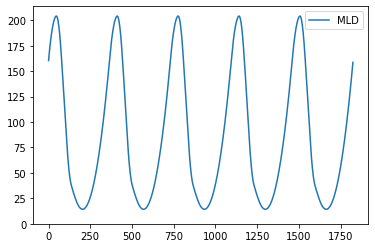

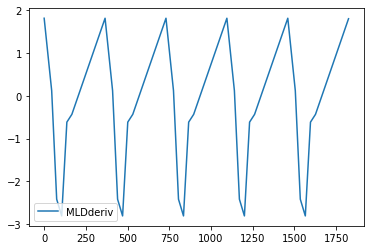

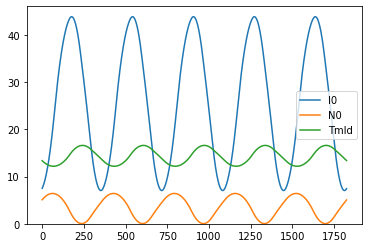

In [19]:
time = odeint_out.Time__time

plt.plot(time, odeint_out.MLD__forcing_value, label='MLD')
plt.ylim(bottom=0)
plt.legend()
plt.show()

plt.plot(time, odeint_out.MLDderiv__forcing_value, label='MLDderiv')
plt.legend()
plt.show()

plt.plot(time, odeint_out.I0__forcing_value, label='I0')
plt.plot(time, odeint_out.N0__forcing_value, label='N0')
plt.plot(time, odeint_out.Tmld__forcing_value, label='Tmld')
plt.ylim(bottom=0)
plt.legend()

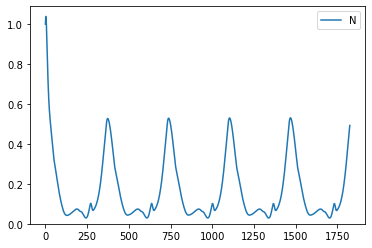

In [20]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.ylim(bottom=0)
plt.legend()

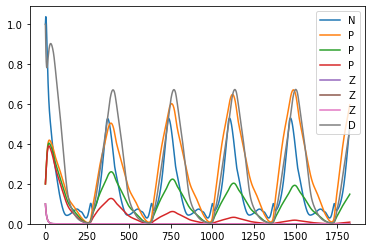

In [21]:
time = odeint_out.Time__time
plt.plot(time, odeint_out.Nutrient__var_value, label='N')
plt.plot(time, odeint_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, odeint_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, odeint_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

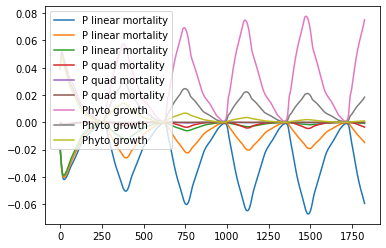

In [23]:
plt.plot(time, -odeint_out.PhytoLinMortality__decay_value.T, label='P linear mortality')
plt.plot(time, -odeint_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, odeint_out.Growth__growth_value.T, label='Phyto growth')

plt.legend()

In [24]:
stepwise_setup = phydra.update_setup(model=NPxZxD, old_setup=odeint_setup, new_solver="stepwise",
                                     new_time=np.arange(0,365*5,.5))

In [25]:
with NPxZxD:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model backend
Initializing Model Time
flux Time_time_flux (3650,)
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Tmld
Initializing component MLD
Initializing component N0
Initializing component MLDderiv
Initializing component I0
Initializing component Upwelling
flux Upwelling_mixing (3650,)
Initializing component Mixing
flux Mixing_mixing (7, 3650)
Initializing component Sinking
flux Sinking_sinking (3650,)
Initializing component PhytoLinMortality
flux PhytoLinMortality_decay (3, 3650)
Initializing component DetRemineralisation
flux DetRemineralisation_decay (3650,)
Initializing component Monod
flux Monod_monod_lim (3, 3650)
Initializing component Eppley
flux Eppley_eppley_growth (3650,)
Initializing component Steele
flux Steele_steele_light_lim (3650,)
Initializing component HigherOrderPred
flux HigherOrderPred_decay (3, 3650)
Initializing component PhytoQuadMor

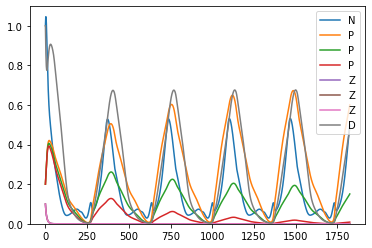

In [26]:
time = stepwise_out.Time__time
plt.plot(time, stepwise_out.Nutrient__var_value, label='N')
plt.plot(time, stepwise_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, stepwise_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, stepwise_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [27]:
# plt.plot(time, stepwise_out.Input__input_value, label='N_input')
# plt.plot(time, -stepwise_out.PhytoLinMortality__decay_value, label='P mortality')
# plt.plot(time, -stepwise_out.PhytoQuadMortality__decay_value, label='P quad mortality')
# plt.plot(time, stepwise_out.Growth__growth_value, label='N uptake')
# plt.plot(time, stepwise_out.Grazing__grazing_value, label='Grazing')
# plt.ylim(bottom=0)
# plt.legend()

In [28]:
gekko_setup = phydra.update_setup(model=NPxZxD, 
                                  old_setup=odeint_setup, 
                                  new_solver="gekko", 
                                  # gekko solver works better (much faster) with smaller time steps:
                                  # new_time=np.arange(0,201,.1)
                                 )

In [29]:
with NPxZxD:
    gekko_out = gekko_setup.xsimlab.run()

initializing model backend
Initializing Model Time
CALCULATING FLUX None
Time_time_flux 1 <class 'int'> None
Flux_OUT time_time_flux
Initializing component Nutrient
Initializing component Phytoplankton
Initializing component Zooplankton
Initializing component Detritus
Initializing component Tmld
Initializing component MLD
Initializing component N0
Initializing component MLDderiv
Initializing component I0
Initializing component Upwelling
CALCULATING FLUX ()
Upwelling_mixing (((((n0-n))*((p38+upwelling_kappa))))/(mld)) <class 'numpy.ndarray'> ()
Flux_OUT upwelling_mixing
Initializing component Mixing
CALCULATING FLUX sinking_vars_full
Mixing_mixing [((((p0)*((p41+mixing_kappa))))/(mld))
 ((((p1)*((p42+mixing_kappa))))/(mld))
 ((((p2)*((p43+mixing_kappa))))/(mld))
 ((((z0)*((p44+mixing_kappa))))/(mld))
 ((((z1)*((p45+mixing_kappa))))/(mld))
 ((((z2)*((p46+mixing_kappa))))/(mld))
 ((((d)*((p47+mixing_kappa))))/(mld))] <class 'numpy.ndarray'> sinking_vars_full
Flux_OUT [0, 0, 0, 0, 0, 0, 0]

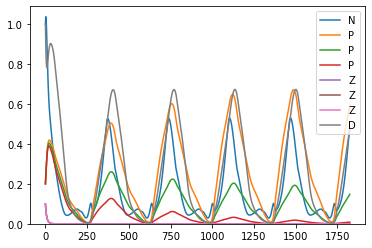

In [30]:
time = gekko_out.Time__time
plt.plot(time, gekko_out.Nutrient__var_value, label='N')
plt.plot(time, gekko_out.Phytoplankton__var_value.T, label='P')
plt.plot(time, gekko_out.Zooplankton__var_value.T, label='Z')
plt.plot(time, gekko_out.Detritus__var_value, label='D')
plt.ylim(bottom=0)
plt.legend()

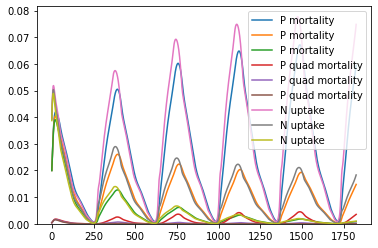

In [31]:
plt.plot(time, gekko_out.PhytoLinMortality__decay_value.T, label='P mortality')
plt.plot(time, gekko_out.PhytoQuadMortality__decay_value.T, label='P quad mortality')
plt.plot(time, gekko_out.Growth__growth_value.T, label='N uptake')
#plt.plot(time, gekko_out.Grazing__grazing_value, label='Grazing')
plt.ylim(bottom=0)
plt.legend()